# Symposium on Molecular Interactions Tutorials
## What is this?? 
This is a Jupyter notebook. It runs Python, but also allows it to be interspersed with Markdown-formatted text, for a nice mixture of documentation and code.

The particular material below is Session 1 of the tutorials on free energy calculations and OpenMM, from Day 1 of the Symposium on Molecular Interactions (2017).

This content is available on the [symposium github repository](https://github.com/QCMM/workshop2017) at [https://github.com/QCMM/workshop2017](https://github.com/QCMM/workshop2017).

This material is a set of slides intended for presentation with RISE (for presentations from Jupyter notebooks). While it may be useful without RISE, it will also likely appear somewhat less verbose than it would if it were intended for use in written form.

## Authors/sources/acknowledgments
Author: David L. Mobley (UCI)

### Sources
- Much of content adapted from materials I have developed or am developing for my [Drug Discovery Computing Techniques class](https://github.com/mobleylab/drug-computing).

### Acknowledgments
- John Chodera and Nathan Lim for help with OpenMM
- OpenEye for help with OpenEye software, especially James Haigh

# Before we get going, pick your favorite molecule and start a hydration free energy calculation

- Navigate to `solvation_free_energies` under workshop material
- Type `python run_hydration.py --name=yourmoleculename` or `python run_hydration.py --smiles=SMILES` to start an implicit solvent hydration free energy calculation; replace `yourmoleculename` with an IUPAC name of your favorite small, fairly rigid molecule (e.g. phenol) or `SMILES` with a SMILES string
- Let's have a volunteer (or two) for each of these FreeSolv compounds: phenol, toluene, cyclohexane, propanethiol, pentan-3-one, nitromethane, nonane, 1,4-dichlorobenzene
- We'll analyze the results of this later



Aside: I'll assume throughout that you know how to navigate the command prompt, open and edit text files, etc. If not, (such as due to unfamiliarity with the OS) please ask us for help.

# Outline of this afternoon's first session
1. Orientation about GitHub
2. Preparing and working with small molecules/organic molecules
3. About that hydration free energy calculation...
4. Analysis of a hydration calculation
5. How to know if your results are in good shape

**To follow along**/run code: Open this Jupyter notebook in `solvation_free_energies/Session1.ipynb` via `jupyter notebook Session1.ipynb`. (See [prerequisites](../prerequisites.md) if you aren't using preinstalled software.)


# Orientation/about GitHub

- This material is [on GitHub](https://github.com/QCMM/workshop2017)
- You should have a copy of it on your computer
- If not, you can get it at [https://github.com/QCMM/workshop2017](https://github.com/QCMM/workshop2017), and it can be useful to browse the web interface for reference/documentation.
- To get a copy, visit the GitHub repo:

## Copy Git link from "clone or download" then retrieve on your computer

If you don't already have it, copy the below link, then `git clone https://github.com/QCMM/workshop2017.git` on your computer, then `cd workshop2017`. Updates can be retrieved by `git pull origin master`.

<img src="images/github_use.png" alt="GitHub" style="width: 1000px;" align="right"/>



# Working with small molecules/organic molecules

- MD packages tend not to "know chemistry", just biopolymers
- So you need a chemistry toolkit
- We'll use the OpenEye toolkits here a lot (great tools, free academic license available)
- RDKit is an open alternative

In the context of free energy calculations, you need a chemistry toolkit to help you set up the molecules you want, assign partial charges, handle symmetries, etc. 

Yank, the code you used above, uses OpenEye toolkits to handle chemistry so it can handle various inputs. But what if you want to prepare your own?

## Let's start with molecule generation from [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)

In [1]:
# Import OpenEye toolkits we need 
from openeye.oechem import * #General chemistry toolkit
from openeye.oeiupac import * #For working with molecule names
import oenotebook as oenb # Handy OpenEye plugins for Jupyter notebooks
print("Is your OEChem licensed?", oechem.OEChemIsLicensed()) #Check it's working!

Is your OEChem licensed? True


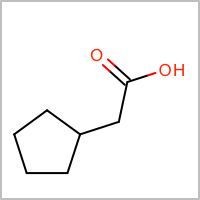

In [2]:
# Create a basic OpenEye molecule
mol = OEMol()

# Parse a SMILES string to this molecule
oechem.OESmilesToMol(mol, 'OC(CC1CCCC1)=O')

# Depict!
oenb.draw_mol(mol)

## Molecule generation from IUPAC names

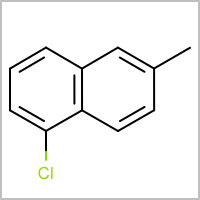

In [3]:
# Generate new molecule
mol_from_name = OEMol()

# Store a name
mol_name = '1-chloro-6-methylnaphthalene'

#Parse name
OEParseIUPACName(mol_from_name, mol_name)

#Depict
oenb.draw_mol(mol_from_name)

In [4]:
# OK, but maybe I LIKE SMILES
print(OECreateIsoSmiString(mol_from_name))

Cc1ccc2c(c1)cccc2Cl


## Conformer generation: If you're going to use it in a simulation, you need 3D

`Omega` is the OpenEye conformer-generation toolkit; very focused on organics, but quite good and fast.
Aims at generating reasonably-likely solution-phase conformers, NOT at predicting THE conformation. Tends to be quite good at generating conformers near likely minima.

In [5]:
from openeye.oeomega import *
omega = OEOmega() #initialize class
omega.SetMaxConfs(1) # Only generate one for now

print("Number of atoms before conformer generation (heavy atoms only): ", mol.NumAtoms())
omega(mol)
print("Number of atoms after conformer generation (includes hydroges): ", mol.NumAtoms())

Number of atoms before conformer generation (heavy atoms only):  9
Number of atoms after conformer generation (includes hydroges):  21


## Partial charge assignment

Often, QM calculations are used to assign partial charges for molecules. However, AM1-BCC charges see widespread use as they are fit to be similar to HF/6-31G* RESP charges used for many FFs when originally developed (such as AMBER).
OpenEye tools provide an easy interface to claculate these

In [6]:
from openeye.oequacpac import * #quacpac has tools for working with charges, tautomers, etc.

#Initialize charge generation
chargeEngine = OEAM1BCCCharges()

# Set to use a simple neutral pH model; will make some attempt to pick a protonation state reasonably likely at 
# neutral pH (not accurate)
OESetNeutralpHModel(mol)

# Generate charges
OEAssignCharges(mol, chargeEngine)

True

## Looping over atoms and getting properties

In [7]:
# One can easily loop over atoms and get various properties
OETriposAtomNames(mol) #Assign names so the atoms will have useful names

# Loop over atoms
for atom in mol.GetAtoms():
    # Print some info for non-hydrogen atoms
    if not atom.IsHydrogen():
        print("Name: %s, formal charge: %d, partial charge %.3g" % 
           (atom.GetName(), atom.GetFormalCharge(), atom.GetPartialCharge()))

Name: C1, formal charge: 0, partial charge 0.91
Name: C2, formal charge: 0, partial charge -0.0773
Name: C3, formal charge: 0, partial charge -0.0773
Name: C4, formal charge: 0, partial charge -0.0784
Name: C5, formal charge: 0, partial charge -0.0784
Name: C6, formal charge: 0, partial charge -0.0482
Name: C7, formal charge: 0, partial charge -0.189
Name: O1, formal charge: 0, partial charge -0.852
Name: O2, formal charge: -1, partial charge -0.852


You can loop over bonds, too. The [OpenEye documentation](https://docs.eyesopen.com) is good and complete.

## File I/O

OpenEye supports reading to/writing from a pretty significant number of file formats; 30K+ lines of code, but all you need to know is:

In [8]:
# Generate new molecule
new_molecule = OEMol()
# Open input stream
ifile = oemolistream('sample_files/mobley_20524.mol2')

# Read molecule
OEReadMolecule(ifile, new_molecule)
print(new_molecule.NumAtoms())
# Close inputstream
ifile.close()

13


In [9]:
# Write out to another file format - try picking YOUR favorite for fun.

# Open ouput stream
ofile = oemolostream('sample_files/mobley_20524.pdb')
OEWriteMolecule(ofile, new_molecule)
ofile.close()

In [10]:
# If you have nglview installed, you should be able to visualize inline using MDTraj and nglview.
# An alternative is to drop out and use VMD.
import nglview
import mdtraj

# Load file
traj = mdtraj.load('sample_files/mobley_20524.mol2')

# View using nglview
view = nglview.show_mdtraj(traj)
view

/Users/dmobley/anaconda3/envs/workshop_test/lib/python3.6/site-packages/pandas/io/parsers.py:2218: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/dmobley/anaconda3/envs/workshop_test/lib/python3.6/site-packages/pandas/io/parsers.py:2220: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


NGLWidget()

## Common gotchas/things to watch out for

- PDB file loads
- unspecified stereochemistry
- isomeric SMILES/canonical SMILES (stereochemistry is important!)
- ambiguous IUPAC names
- file names: Don't use molecule names (which can contain commas, italics, and various special characters) as file names
- IUPAC is just not a good representation; for general molecule identifiers, use SMILES or mol2 files.

# About that hydration free energy calculation: It's using [Yank](http://getyank.org/latest/)...

- OpenMM-based package for free energy calculations
- OpenMM: More a simulation toolkit than a package (see Session 2)
- Binding free energy calculations, solvatio free energy calculations
- `run_hydration.py` just an even-simpler command-line interface to Yank's command-line or python interfaces
- We'll take a look at what it's doing

Check out `run_hydration.py`, e.g. with `vi run_hydration.py`

## Yank uses a flexible YAML syntax for input files/input instructions


<img src="images/yaml1.png" alt="GitHub" style="width: 1000px;" align="right"/>
The [YAML cookbook](http://getyank.org/latest/yamlpages/cookbook.html) provides a good entry point (concrete examples). Here's some of ours:


- Many self-explanatory
- [options](http://getyank.org/latest/yamlpages/options.html) gives basic simulation options
    - include how often (in steps) to write checkpoint files, whether or not to write data for resuming, the number of iterations to run, the timestep, etc.
    - Hamiltonian replica exchange simulations, hence "iterations"
- `anisotropic_dispersion_cutoff`: Compute and include anisotropic dispersion correction for cutoff long range dispersion interactions past this cutoff.
- [molecules](http://getyank.org/latest/yamlpages/molecules.html) can be from `filepath` (SDF, PDB, mol2, .csv (SMILES)),  `smiles`, or `name` (IUPAC name)
    - Defines what molecules used in your systems
    - Built whether or not they are used

### More of that YAML file:

<img src="images/yaml2.png" alt="YAML" style="width: 1000px;" align="right"/>

- [solvents](http://getyank.org/latest/yamlpages/solvents.html): Specifies what solvents are available, including vacuum
- Here, defines TIP3P, GBSA (OBC2 GBSA model), vacuum
- [systems](http://getyank.org/latest/yamlpages/systems.html): Specifies what systems (`molecules` plus `solvents`) are to be prepared, with user-defined names
- Here, provides names of AMBER parameter files to use in setting up system (solvent, protein (not present here), small molecules)
- Uses GAFF small molecule force field

###  Protocols: $\lambda$ schedule for potential protocols

<img src="images/yaml3.png" alt="YAML" style="width: 1400px;" align="right"/>

- [protocols](http://getyank.org/latest/yamlpages/protocols.html): Defines what alchemical path to follow
- Several protocols can be specified with different names
- Here we follow typical protocols from [alchemistry.org](http://alchemistry.org) -- first turn off charges, then steric interactions
- Depending on whether solvent is present or not we can use different $\lambda$ spacing and number of $\lambda$ values
- In some cases an `auto` path determination may be useful (and is available)

### Final phase: What experiments are you running?

<img src="images/yaml4.png" alt="YAML" style="width: 1400px;" align="right"/>

Here, a command-line option switches between implicit and explicit solvent protocols, on the `hydration` system, which uses TIP3P or GBSA implicit solvent depending on the command-line option.

What you ran was in GBSA implicit solvent.

- [experiments](http://getyank.org/latest/yamlpages/experiments.html) details what you actually run
- you can configure multiple experiments at once
- combinatorial experiments are also possible

# Analyzing a hydration free energy calculation

Basic analysis is done by `yank analyze -s data/experiments` or similar, where `data` is your output directory and your experiments are configured under `experiments`. Here:

<img src="images/results.png" alt="results" style="width: 1400px;" align="left"/>

This is an implicit solvent hydration calculation of phenol. Key value: $-5.971\pm0.005$ kcal/mol, estimated via [MBAR](http://www.alchemistry.org/wiki/Multistate_Bennett_Acceptance_Ratio) ([`pymbar`](http://pymbar.readthedocs.io) Python package)

## You should be able to try analyzing yours now

`yank analyze -s data/experiments`

If it's still running, let's use sample data in this repository:
- Extract sample_files/hydration.tar.gz (`tar -xvf hydration.tar.gz`)
- `cd` there to the `hydration/hydration-out` directory
- `yank analyze -s experiments`
- Keep your value; I'll need it from you in a minute

## Let's analyze as a class and see how we do
We'll try and make a graph of your results.

In [11]:
# We'll load FreeSolv v0.52 into a Pandas dataframe
import pandas as pd
molecule_names = ['phenol', 'toluene', 'cyclohexane', 'propanethiol', 'pentan-3-one', 'nitromethane', 'nonane', '1,4-dichlorobenzene']
freesolv = pd.read_json('sample_files/database.json', orient='index')

# Load experimental values from FreeSolv
expt_values = [ freesolv[freesolv.iupac==n].iloc[0]['expt'] for n in molecule_names ]

# Load PREVIOUSLY calculated values from FreeSolv
calc_values = [ freesolv[freesolv.iupac==n].iloc[0]['calc'] for n in molecule_names ]

# Now we'll input your values here
molecule_names = ['phenol', 'toluene', 'cyclohexane', 'propanethiol', 'pentan-3-one', 'nitromethane', 'nonane', '1,4-dichlorobenzene']
#calc_values =   []

In [12]:
# Now we build a pandas dataframe of the molecules and data
molecules = []
for name in molecule_names:
    mol = OEMol()
    OEParseIUPACName(mol, name)
    molecules.append(mol)

# Put in a dataframe
df = pd.DataFrame({ 'names': molecule_names,
                    'Molecule': molecules,
                    'DeltaG_calc': calc_values,
                    'DeltaG_expt': expt_values
})

## Now let's do a fancy plot

If you want to plot this way, you'll need to install `bokeh`:
- drop out to command-line
- `conda install bokeh`
- Go to kernel -> restart kernel
- Re-run the imports at the top of the notebook and the "let's analyze as a class" downwards
- Otherwise I give an alternate plot further down

In [13]:
# This draws on http://notebooks.eyesopen.com/molecule-plots.html
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.models import HoverTool, Callback
from collections import OrderedDict

# Configure default tools for plots
TOOLS = 'box_zoom,box_select,reset,save'

# Configure for output in the notebook
output_notebook()


# Store data in a bokeh object data object and add images
source = ColumnDataSource(df.drop("Molecule",axis=1))
source.add(df.Molecule.apply(lambda x: oenb.draw_mol_to_html(x,300,200)),name="img")

p = figure(title="Molecule", tools=TOOLS)
p.xaxis.axis_label = 'DeltaG_calc'
p.yaxis.axis_label = 'DeltaG_expt'

# Make scatterplot
p.circle("DeltaG_calc", "DeltaG_expt", fill_alpha=0.2, size=10, source=source)

# Create tooltips referencing stored images
tooltips = """<img src=@img>"""

# Connect tooltips to plot
p.add_tools(HoverTool(tooltips=tooltips))

# Uncomment to create a html file of the plot.
# output_file("bokeh_plot.html")

Loading BokehJS ...

In [14]:
show(p)

In [15]:
# There should be simpler ways to do the above, such as 
# f,a = oenb.scatter_mpl(df,"DeltaG","dDeltaG") 
# and
# f = oenb.scatter_bokeh(df,"DeltaG","dDeltaG")
# but these seem to be currently broken with the latest `oenotebook` due to version changes.

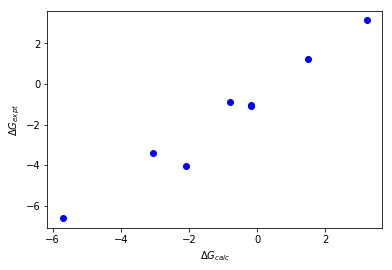

In [16]:
# The simple, old-fashioned way
%matplotlib inline
from pylab import *

xlabel(r'$\Delta G_{calc}$')
ylabel(r'$\Delta G_{expt}$')
plot( df.DeltaG_calc, df.DeltaG_expt, 'bo')

# Explicit solvent results for cyclopentanol in water:
<img src="images/results.jpg" alt="results" style="width: 1400px;" align="left"/>


Enthalpy very hard to estimate accurately without very long simulations.

# Analyzing whether your hydration free energy calculation worked/behaved itself

- Error analysis above: Works well when enough or nearly enough data, but unreliable as data/overlap becomes problematic
- Yank provides a facility to get a much more detailed view of the "health" of your calculations
- In the `hydration-out` directory, run `yank analyze report --store=experiments --output=hydration_1ns.ipynb`
- Open the resulting jupyter notebook (`jupyter notebook hydration_1ns.ipynb`) and run the contents
- I've put a copy of the results in [`sample_files/hydration_1ns.html`](sample_files/hydration_1ns.html); **let's visualize that now** and discuss.